## JPLDD Demo Notebook
In this notebook we demonstrate the functionality of JPLDD. Using a single image we show how to action: 1) Heatmap generation, 2) Keypoint detection, 3) Line Detection, 4) Descriptor extraction

In [1]:
import torch
import flow_vis
import numpy as np
from matplotlib import pyplot as plt
import cv2
from torchvision.transforms import Resize
from pytlsd import lsd
import sys
import os
notebook_dir = os.getcwd()
sys.path.append(os.path.join(notebook_dir, '..'))
from gluefactory.models import get_model
from gluefactory.models.extractors.jpldd.line_detection_jpldd import detect_jpldd_lines
from sklearn.decomposition import PCA

In [2]:
plt.rcParams["figure.figsize"] = (7,7)

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_built():
    device = 'mps'
else:
    device = 'cpu'
device = 'cpu'
device

'cpu'

In [4]:
def get_flow_vis(df, ang, line_neighborhood=5):
    norm = line_neighborhood + 1 - np.clip(df, 0, line_neighborhood)
    flow_uv = np.stack([norm * np.cos(ang), norm * np.sin(ang)], axis=-1)
    flow_img = flow_vis.flow_to_color(flow_uv, convert_to_bgr=False)
    return flow_img

def numpy_image_to_torch(image):
    """Normalize the image tensor and reorder the dimensions."""
    if image.ndim == 3:
        image = image.transpose((2, 0, 1))  # HxWxC to CxHxW
    elif image.ndim == 2:
        image = image[None]  # add channel axis
    else:
        raise ValueError(f"Not an image: {image.shape}")
    return torch.tensor(image / 255.0, dtype=torch.float)

Import and visualize demo picture

torch.Size([1, 3, 800, 800])


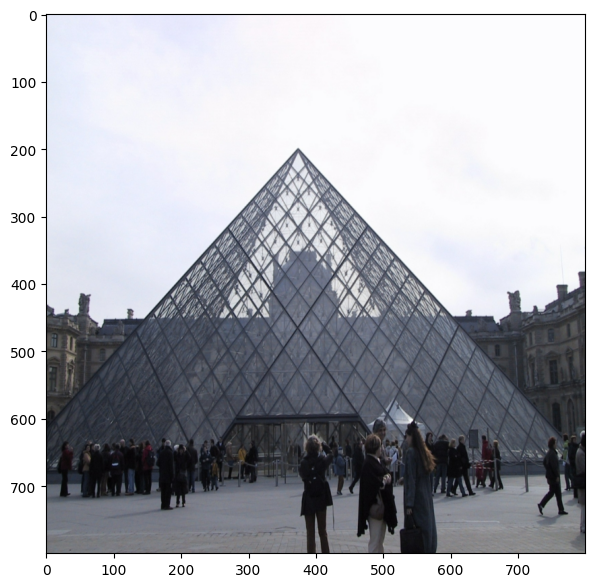

In [5]:
size = (800,800)

resize_func = Resize(size)
image_path = f"demo_louvre.jpg"
img = cv2.resize(cv2.imread(image_path),size)
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_torch = numpy_image_to_torch(img).to(device)
img_torch = img_torch.unsqueeze(0)

print(img_torch.shape)
plt.imshow(rgb_img)
plt.show()

## 1) JPLDD Heatmaps

In [7]:
jpldd_conf = {
    "name": "jpldd.joint_point_line_extractor",
    "max_num_keypoints": 1024,  # setting for training, for eval: -1
    "timeit": True,  # override timeit: False from BaseModel
    "line_df_decoder_channels": 32,
    "line_af_decoder_channels": 32,
    "line_detection": {
        "do": False
    },
    # "checkpoint": None
}
jpldd_model = get_model("jpldd.joint_point_line_extractor")(jpldd_conf).to(device)
jpldd_model.eval()

JointPointLineDetectorDescriptor(
  (encoder_backbone): AlikedEncoder(
    (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (pool4): AvgPool2d(kernel_size=4, stride=4, padding=0)
    (gate): SELU(inplace=True)
    (block1): ConvBlock(
      (gate): SELU(inplace=True)
      (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (block2): ResBlock(
      (gate): SELU(inplace=True)
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn

In [8]:
%%time

with torch.no_grad():
    output_jpldd = jpldd_model({"image": img_torch})
output_jpldd.keys()

CPU times: user 20.5 s, sys: 5.87 s, total: 26.4 s
Wall time: 4.23 s


dict_keys(['keypoint_and_junction_score_map', 'line_anglefield', 'line_distancefield', 'keypoints_raw', 'keypoints', 'keypoint_scores', 'descriptors'])

In [9]:
jpldd_kpjhm = output_jpldd['keypoint_and_junction_score_map'][0]
jpldd_af = output_jpldd['line_anglefield'][0]
jpldd_df = output_jpldd['line_distancefield'][0]
jpldd_kpr = output_jpldd['keypoints_raw'][0]
jpldd_kp = output_jpldd['keypoints'][0]
jpldd_kp_scores = output_jpldd['keypoint_scores'][0]
jpldd_desc = output_jpldd['descriptors'][0]

jpldd_kpjhm.shape, jpldd_af.shape, jpldd_df.shape, jpldd_kpr.shape, jpldd_kp.shape, jpldd_kp_scores.shape, jpldd_desc.shape

(torch.Size([800, 800]),
 torch.Size([800, 800]),
 torch.Size([800, 800]),
 torch.Size([1024, 2]),
 torch.Size([1024, 2]),
 torch.Size([1024]),
 torch.Size([1024, 128]))

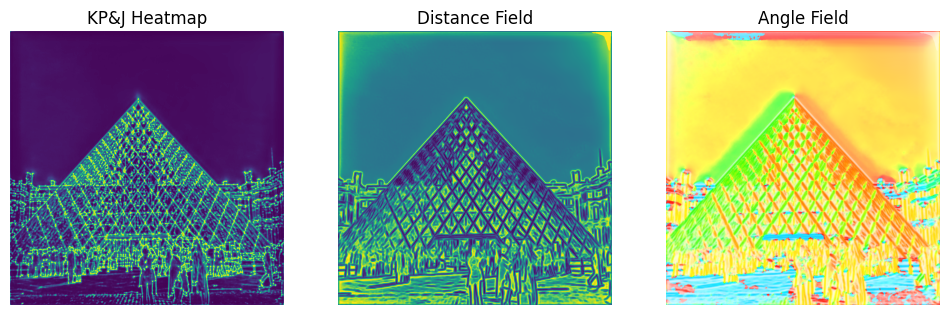

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].axis('off')
ax[0].set_title('KP&J Heatmap')
ax[0].imshow(jpldd_kpjhm)

ax[1].axis('off')
ax[1].set_title('Distance Field')
ax[1].imshow(jpldd_df)

ax[2].axis('off')
ax[2].set_title('Angle Field')
ax[2].imshow(get_flow_vis(jpldd_df, jpldd_af))
plt.show()

## 2) Keypoint detection

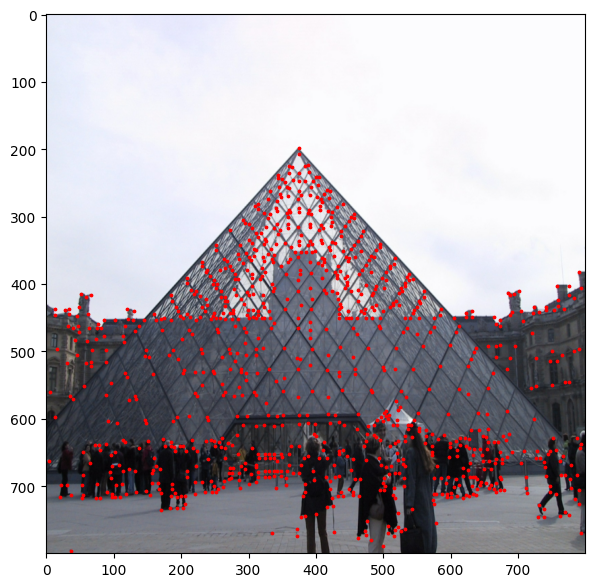

In [11]:
plt.imshow(rgb_img)
plt.scatter(jpldd_kp[:, 0], jpldd_kp[:, 1], c='r', s=3)
plt.show()

## 3) Line Detection

In [12]:
df = jpldd_df
af = jpldd_af
detected_lines = detect_jpldd_lines(
    df, af, jpldd_kp,
    n_samples=64, 
    df_thresh=2, 
    inlier_thresh=0.9,
    a_diff_thresh=np.pi/20,
    a_std_thresh=np.pi/10,
    r_radius = 1,
)
detected_lines.shape

torch.Size([5044, 2, 2])

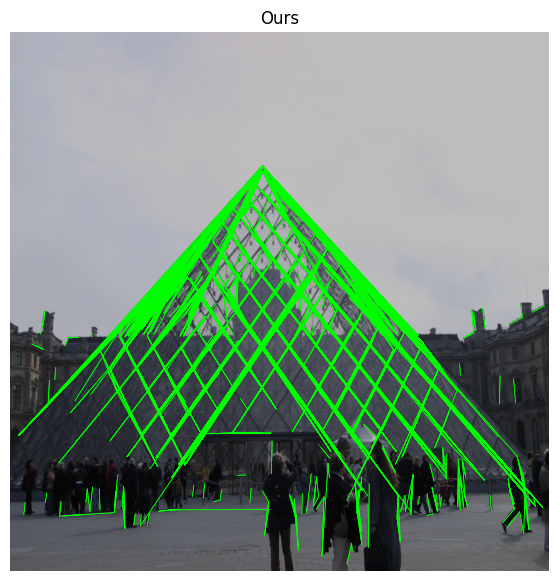

In [13]:
LINE_COLOR = 'lime'
KP_COLOR = 'r'
ALL_KP_COLOR = 'blue'

plt.title('Ours')
plt.axis('off')
# plt.imshow(npdf)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.imshow(np.zeros_like(img), alpha=0.25)
line_segs = detected_lines
valid_xs = line_segs[:, 0]
valid_ys = line_segs[:, 1]
for i in range(len(line_segs)):
    x1, x2 = valid_xs[i]
    y1, y2 = valid_ys[i]
    plt.plot([y1, y2], [x1, x2], c=LINE_COLOR, linewidth=0.5)
# plt.scatter(*junctions.T.numpy()[::-1], c=ALL_KP_COLOR, s=1)
# plt.scatter(valid_ys[:, 0], valid_xs[:, 0], c=KP_COLOR, s=5)
# plt.scatter(valid_ys[:, 1], valid_xs[:, 1], c=KP_COLOR, s=5)
# plt.scatter(lines[:1000, 0, 0], lines[:1000, 1, 0], c=KP_COLOR, s=5)
# plt.legend()
plt.show()

## 4) Descriptor extraction

In [14]:
pca = PCA(n_components=3)
pca.fit(jpldd_desc.numpy())

pca_desc = pca.transform(jpldd_desc)

normalized_pca_desc = pca_desc - pca_desc.min()
normalized_pca_desc = normalized_pca_desc / normalized_pca_desc.max()

normalized_pca_desc

array([[0.12140544, 0.46092825, 0.80605988],
       [0.05993525, 0.42664494, 0.81146019],
       [0.07594203, 0.4500132 , 0.79366142],
       ...,
       [0.65476008, 0.142915  , 0.40435149],
       [0.4753737 , 0.32085964, 0.46209904],
       [0.46662483, 0.95978269, 0.49040047]])

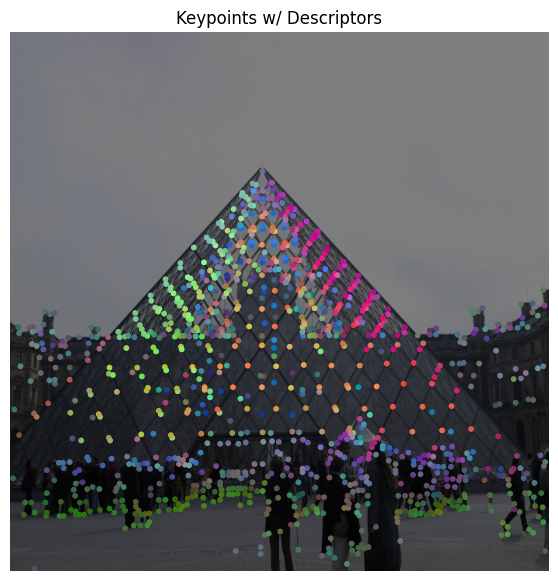

In [15]:
plt.axis('off')
plt.title('Keypoints w/ Descriptors')
plt.imshow(rgb_img)
plt.imshow(np.zeros_like(img), alpha=0.5, cmap='gray')
plt.scatter(jpldd_kp[:, 0], jpldd_kp[:, 1], c=normalized_pca_desc, s=10)
#plt.savefig('../experiments/data/kpd.png')
plt.show()